# Homework 9

In this homework, you will be using a form of attention called *attention pooling* to solve the "addition problem". The addition problem was introduced in the [LSTM paper](https://www.bioinf.jku.at/publications/older/2604.pdf) as a way to test whether an RNN could propagate information across many time steps. In the addition problem, the model is given a sequence of 2D vectors in the format:

|     |      |     |     |      |     |      |     |     |     |     |
|-----|------|-----|-----|------|-----|------|-----|-----|-----|-----|
| 0.5 | -0.7 | 0.3 | 0.1 | -0.2 | ... | -0.5 | 0.9 | ... | 0.8 | 0.2 |
| 0   |   0  |  1  |  0  |   0  |     |   0  |  1  |     |  0  |  0  |

The first dimension of each vector in the sequence is a random number between 0 and 1. The second dimension is 0 for all entries of the sequence expect for 2, where it is 1. The goal of the addition problem is to output the sum of the values in the first dimension at the two indices where the second dimension is 1. In the example above, the target would be 0.9 + 0.3 = 1.2. Below is a code snippet that generates a sequence and its target for the addition problem.

In [121]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

def addition_problem(sequence_length=50):
    output = np.random.uniform(-1, 1, (sequence_length, 2))
    output[:, 0] = 0.
    random_indices = np.random.choice(sequence_length, size=2, replace=False)
    output[random_indices, [0, 0]] = 1
    return output, (output[:, 0]*output[:, 1]).sum(keepdims=True)

In [3]:
addition_problem()

(array([[ 0.        ,  0.90787634],
        [ 0.        , -0.72392442],
        [ 0.        ,  0.45645897],
        [ 0.        ,  0.65001662],
        [ 0.        , -0.42878328],
        [ 0.        ,  0.50319949],
        [ 0.        , -0.81027942],
        [ 0.        , -0.57592772],
        [ 0.        ,  0.77575195],
        [ 0.        ,  0.21064778],
        [ 0.        ,  0.61380194],
        [ 0.        , -0.49043025],
        [ 0.        ,  0.52713338],
        [ 0.        , -0.28426923],
        [ 0.        , -0.76214322],
        [ 0.        ,  0.56527765],
        [ 0.        , -0.36905992],
        [ 0.        , -0.35552643],
        [ 0.        ,  0.83273812],
        [ 0.        ,  0.85160927],
        [ 1.        , -0.75418596],
        [ 0.        ,  0.1134291 ],
        [ 0.        , -0.20819938],
        [ 0.        , -0.27355617],
        [ 0.        ,  0.07258713],
        [ 0.        , -0.622459  ],
        [ 0.        ,  0.54978893],
        [ 0.        , -0.175

Attention pooling is a form of attention that allows a model to solve the addition problem without using an RNN. In attention pooling, the query vector $q$ is a *learnable parameter*. The keys and values are both the input sequence. Specifically, given a sequence $\{h_1, h_2, \ldots, h_T\}$, attention pooling computes
\begin{align}
e_t &= \mathrm{a}(q, h_t) \\
\alpha_t &= \frac{\exp(e_t)}{\sum_k \exp(e_k)} \\
c &= \sum_{t = 1}^T \alpha_t h_t
\end{align}
where $\mathrm{a}(q, h_t)$ is the attention energy function. Note that c will always be a fixed-length vector (which amounts to a weighted average of the elements of the sequence $h$) regardless of how long the sequence is (i.e. the value of $T$). $\mathrm{a}(q, h_t)$ can be any function that takes in a single entry of the sequence $h_t$ and outputs an unnormalizes scalar value. One option is to use
$$\mathrm{a}(q, h_t) = q^\top \tanh(W_a h_t + b_a)$$
where $q \in \mathbb{R}^q$, $W_a \in \mathbb{R}^{q \times d}$, and $b_a \in \mathbb{R}^q$ are learnable parameters, and $d$ is the dimensionality of $h_t$ (i.e. $h_t \in \mathbb{R}^d$).


1. Build and train a neural network that uses attention pooling to solve the addition problem. The model should output a scalar which corresponds to the target value for the addition problem (i.e. the sum of the sequence entries that are marked with a "1"). Here, "solved" means that the squared error of the model's predicitons is always below $0.05$. Use a sequence length of $50$ (which is the default for the `addition_problem` function defined above). *Hints*:
  1. This is a regression problem. Your model should predict a continuous scalar value and you can use a squared-error loss.
  1. The point of the attention pooling layer is to allow you to put it in an otherwise feed-forward network. So, consider just using simple dense feed-forward layers before and/or after the attention pooling layer. To start, you can try the architecture: feed-forward, attention pooling, feed-forward, output layer.
  1. If you are finding that the model is getting stuck at a non-zero squared error, it could be that it's just outputting the mean value and having trouble learning a good solution. Try different initialization, nonlinearities, architecture, learning rate, etc.
1. Once you have trained a model that gets solid performance at sequence length $50$, plot the model's average squared error for sequence lengths $50, 55, 65, 80, 100, 125, 150$. You should generate this plot by averaging the squared error over at least $100$ sequences of a given length. Does the model's error get worse (go up) for longer sequences, or does it generalize to longer sequence lengths?

## Problem 1. Attention Pooling to Solve the Addition Problem 

Model specs:
* Outputs a scalar that corresponds to target value
* Squared Error is below 0.05
* Use a sequence of length 50

### Creating the Class Architectures

In [94]:
class AttentionPooling(nn.Module):

    def __init__(self, hidden_dim=2, query_dim=5):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim

        self.query_vec = nn.Parameter(torch.rand(query_dim))
        self.linear = nn.Linear(hidden_dim, query_dim, bias=True)


    def forward(self, H):
        """
        The vectorized attention energy function 
        Currently implemented for bsz of 1.
        ========================================

        Inputs:
        _______

        H: The matrix representation of the sequence (seq_len=T, embedding_dim=d)

        Outputs:
        ________

        c: A fixed length vector that has 
        """
        # The vector e is of dim (seq_len)
        e = self.query_vec @ torch.transpose(torch.tanh(self.linear(H)), -2, -1)
        # The vector alpha is of dim (seq_len)
        alpha = F.softmax(e, dim=0).unsqueeze(2).expand(-1, -1, self.hidden_dim)
        # C returns the weighted averages * values along the seq dimension axis 
        # (Dim=)
        c = (alpha * H).sum(dim=1)
        return c

class MLP(nn.Module):
    # Implements Fully Connected Multilayer Perceptron With a One-Dimensional Scalar Output
    def __init__(self, input_dim, m_layers):
        super().__init__()
        # Get all the power of twos <= input_dim and sample equidistantly from them
        self.layer_dims = [input_dim] + list(
            reversed(self._sample_list(self._powers_of_two(input_dim - 1), m_layers))
        )
        self.layers = list(self._get_hidden_layers()) + [
            nn.Linear(self.layer_dims[-2], 1)
        ]
        self.fc = nn.Sequential(*self.layers)
        self.input_dim = input_dim

    def forward(self, x):
        # Implement forward pass through the neural network
        output = self.fc(x)
        return output

    @staticmethod
    def _sample_list(list_, n):
        """
        Sample 'n' items from 'list_' in equal distance.
        """
        if n <= 0:
            return []
        if n >= len(list_):
            return list_

        step = (len(list_) - 1) / float(n - 1)
        indices = [int(round(i * step)) for i in range(n)]
        return [list_[i] for i in indices]
    
    @staticmethod
    def _powers_of_two(n):
            highest_power = math.floor(math.log2(n))
            return [2**i for i in range(highest_power + 1)]
        
    def _get_hidden_layers(self):
        for i in range(len(self.layer_dims) - 2):
            yield nn.Linear(self.layer_dims[i], self.layer_dims[i + 1])
            yield nn.ReLU()

In [95]:
class AttentionPoolingNet(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, stem_layers, head_layers):
        super().__init__()
        self.stem = [nn.Linear(input_dim, hidden_dim)] + [nn.Linear(hidden_dim, hidden_dim), nn.ReLU()]*(stem_layers-1)
        self.ap = [AttentionPooling(hidden_dim)]
        self.head = [MLP(hidden_dim, head_layers)]
        layers = self.stem + self.ap + self.head
        self.net = nn.Sequential(*layers)

    def forward(self, H):
        """
        Forward through the network
        ========================================

        Inputs:
        _______

        H: The matrix representation of the sequence (seq_len=T, embedding_dim=d)

        Outputs:
        ________

        outs: A scalar that will converge to the sum of the addition problem hopefully 
        """

        outs = self.net(H)
        return outs


In [130]:
class AdditionProblemDataset(torch.utils.data.Dataset):
    def __init__(self, sequence_length, epoch_size):
        self.seq_len = sequence_length
        self.data = [addition_problem(self.seq_len) for i in range(epoch_size)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    def collate_fn(self, batch):
        # Batch is a list of tuples
        inputs, labels = zip(*batch)
        x = torch.tensor(np.stack(inputs, axis=0), dtype=torch.float32)
        y = torch.tensor(np.stack(labels, axis=0), dtype=torch.float32)
        return x, y
        
    def create_dataloader(self, batch_size, shuffle):
        return torch.utils.data.DataLoader(
            dataset=self,
            batch_size=batch_size,
            collate_fn=self.collate_fn,
            shuffle=shuffle,
            pin_memory=True,
            drop_last=False
        )


class Trainer:
    """
    f(x): 
    ----- 
    """
    def __init__(self, model, loss_fxn, lr, optimizer, scheduler=None, patience=5, device=None):
        self.model = model.to(device)
        self.loss_fxn = loss_fxn
        self.lr = lr
        self.optimizer = optimizer
        self.scheduler = scheduler(self.optimizer) if scheduler is not None else scheduler
        self.patience = patience
        self.device = device
        self.history = None

    def __str__(self):
        return f"Trainer Object with Loss F(x):{self.loss_fxn}, Optimizer:{self.optimizer.__class__}, Scheduler:{str(self.scheduler.__clas__)},"

    def train_step(self, batch):
        """2.Perform One Training Step."""
        inputs, targets = batch[0].to(self.device), batch[1].to(self.device)           
        self.optimizer.zero_grad()                                           # Reset gradients along the graph
        outs = self.model(inputs)                                            # Get the outputs
        loss = self.loss_fxn(outs, targets)                                  # Compute the loss for the batch
        loss.backward()                                                      # Back-Prop to Compute Gradients
        self.optimizer.step()                                                # Use gradients to update parameters
        return loss.detach().item()                                          # NN returns batch average of the loss

    def test_step(self, batch, predict=False):
        """Perform Model Eval for One Batch"""
        with torch.no_grad():
            inputs, targets = batch[0].to(self.device), batch[1].to(self.device)  
            outs = self.model(inputs)                                     # Get the outputs
            loss = self.loss_fxn(outs, targets)                                 # Compute the loss for the batch
            if predict:
                return outs, targets                                            # Return the preds and targets
            else:
                return loss.detach().item()                                     # NN returns batch average of the loss

    def loss_snapshot(self, dataloader):
        """
        Snapshot model loss based on given (criterion)
        across the entire dataset during training.
        Freeze the model weights to not train during calc of loss.

        Inputs:
        data_loader : Data Loader object by pytorch. Iterator of tuples
                    containing zipped inputs and labels.
        """
        running_loss = 0
        dataset_size = 0
        with torch.no_grad():
            for batch in dataloader:
                bsz = len(batch[-1])
                running_loss += self.test_step(batch) * bsz                 # Add the non-averaged batch loss
                dataset_size += bsz
        return running_loss/dataset_size

    def acc_snapshot(self, dataloader):
        """
        Snapshot model accuracy [either binarized or continuous score for the purposes
        of exploring binary vs continuous trained output] across the entire dataset
        during training. Freeze the model weights to not train during calc of loss.

        Inputs:
        dataloader : Data Loader object by pytorch. Iterator of tuples
                    containing dict of inputs and labels.
        """
        num_correct = 0
        dataset_size = 0

        with torch.no_grad():
            for batch in dataloader:
                outs, targets = self.test_step(batch, predict=True)
                outs = outs.squeeze()
                predicted = outs.cpu().numpy()
                # Total the number of examples
                dataset_size += len(targets)
                # Total correct predictions
                matches = np.isclose(predicted, targets.cpu().numpy(), atol=5e-2)       
                num_correct += np.count_nonzero(matches)
        return num_correct/dataset_size

    def train_epochs(self, num_epochs, train_loader, val_loader, log_every=10):
        setattr(self, 'history', {})
        # Instantiate early stopping criteria
        best_model = self.model
        best_val_loss = np.inf
        actual_patience = self.patience

        train_losses = []
        val_losses = []
        train_accs = []
        val_accs = []

        for ep in range(num_epochs):
            for i, batch in enumerate(train_loader):                    # Loop through the batches of the dataloader
                train_loss = self.train_step(batch)                     # Don't need to save per-step loss

            if ep % log_every == 0:                                     # If reached the logging frequency
                train_losses += [self.loss_snapshot(train_loader)]           # Snapshot Model Acc and Los
                val_losses += [self.loss_snapshot(val_loader)]
                train_accs += [self.acc_snapshot(train_loader)]
                val_accs += [self.acc_snapshot(val_loader)]
                print(
                    f"Epoch: {ep + 1} | "
                    f"train_loss: {train_losses[-1]:.5f}, "
                    f"val_loss: {val_losses[-1]:.5f}, "
                    f"train_acc: {train_accs[-1]:.3f}, "
                    f"val_acc: {val_accs[-1]:.3f}, "
                    f"lr: {self.optimizer.param_groups[0]['lr']:.2E}"
                )

            # On-epoch End

            epoch_val_loss = self.loss_snapshot(val_loader)             # Grab the last val_loss @epoch end
            if epoch_val_loss < best_val_loss:                          # Check if current val loss < prev best
                best_val_loss = epoch_val_loss                          # Update best_val_loss
                best_model = self.model                                 # Cache the best model
                actual_patience = self.patience
            else:
                actual_patience -= 1

            if actual_patience == 0:
                print(
                    f'Stopping after validation loss increased for {self.patience} epochs'
                )
                break

            if self.scheduler is not None:
                self.scheduler.step()                                   # Step through the LR schedule

        self.history["train_loss"] = train_losses
        self.history["val_loss"] = val_losses
        self.history["train_acc"] = train_accs
        self.history["val_acc"] = val_accs

        return best_model

In [139]:
# Define Constants

SEQ_LEN = 50
loss_fxn = nn.MSELoss()
lr = .01


# Create the Datasets and Data Loaders
train_dset = AdditionProblemDataset(sequence_length=SEQ_LEN, epoch_size=10000)
val_dset = AdditionProblemDataset(sequence_length=SEQ_LEN, epoch_size=1000)
train_loader = train_dset.create_dataloader(64, shuffle=True)
val_loader = val_dset.create_dataloader(64, shuffle=False)

# Set up the Model

model = AttentionPoolingNet(input_dim=2, hidden_dim=16, stem_layers=4, head_layers=4)
optimizer = torch.optim.Adam(model.parameters())

In [140]:
trainer = Trainer(model, loss_fxn, lr, optimizer, scheduler=None, patience=100, device=None)
opt_model = trainer.train_epochs(1000, train_loader, val_loader, log_every=10)

Epoch: 1 | train_loss: 0.87468, val_loss: 0.82951, train_acc: 2.426, val_acc: 2.856, lr: 1.00E-03
Epoch: 11 | train_loss: 0.12531, val_loss: 0.12340, train_acc: 2.447, val_acc: 2.535, lr: 1.00E-03
Epoch: 21 | train_loss: 0.09769, val_loss: 0.09642, train_acc: 2.360, val_acc: 2.394, lr: 1.00E-03
Epoch: 31 | train_loss: 0.07919, val_loss: 0.08044, train_acc: 2.338, val_acc: 2.411, lr: 1.00E-03
Epoch: 41 | train_loss: 0.07073, val_loss: 0.06919, train_acc: 2.377, val_acc: 2.391, lr: 1.00E-03
Epoch: 51 | train_loss: 0.05861, val_loss: 0.05469, train_acc: 2.353, val_acc: 2.362, lr: 1.00E-03
Epoch: 61 | train_loss: 0.03794, val_loss: 0.03894, train_acc: 2.399, val_acc: 2.390, lr: 1.00E-03
Epoch: 71 | train_loss: 0.01783, val_loss: 0.02002, train_acc: 2.512, val_acc: 2.496, lr: 1.00E-03
Epoch: 81 | train_loss: 0.00688, val_loss: 0.00882, train_acc: 2.655, val_acc: 2.691, lr: 1.00E-03
Epoch: 91 | train_loss: 0.00934, val_loss: 0.01068, train_acc: 2.302, val_acc: 2.354, lr: 1.00E-03
Epoch: 101 

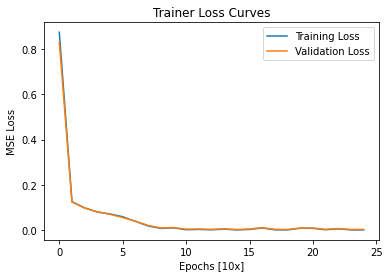

In [147]:
plt.plot(trainer.history['train_loss'])
plt.plot(trainer.history['val_loss'])
plt.title('Trainer Loss Curves')
plt.xlabel('Epochs [10x]')
plt.ylabel('MSE Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()


In [160]:
sample_x, sample_y = addition_problem(50)
x = torch.tensor(sample_x, dtype=torch.float32).unsqueeze(0)

In [161]:
opt_model(x)

tensor([[12.2299]], grad_fn=<AddmmBackward0>)

In [162]:
sample_y

array([0.69461102])

In [171]:
x.sum(2)

tensor([[-0.4327, -0.9616, -0.8102, -0.0793, -0.5470,  0.0204, -0.4467,  0.6626,
         -0.7826, -0.7224,  0.3583,  0.5303, -0.6930, -0.5828,  0.5424, -0.4095,
          0.2433, -0.9866,  0.0056,  0.9631,  0.4130, -0.4019,  0.3124,  0.0021,
         -0.4272, -0.4639,  0.8382, -0.9234,  0.7764,  0.5609,  0.0057,  0.0844,
          0.3062,  0.6828, -0.8319,  0.0846, -0.4475,  0.8723, -0.9312,  0.4161,
          0.6891,  0.4109, -0.6990,  1.1018, -0.6063,  0.9669,  1.5928,  0.7752,
          0.7654, -0.7487]])

### Disclaimer:

Unfortunately, I was not able to debug the issue with the code due to circumstantial reasons. Therefore submitting as is in hopes that some readily apparent stupid mistake is found during grading. 